In [78]:
import os
import sys
import json
import glob
import h5py
import tqdm
import time
import numpy as np
import scipy.signal
import scipy.interpolate
import scipy.io
import scipy.io.wavfile
import soundfile as sf
import soxr
import matlab.engine

%matplotlib inline
import matplotlib.pyplot as plt
import IPython.display as ipd

sys.path.append('/om2/user/msaddler/python-packages/msutil')
import util_figures
import util_stimuli
import util_misc


In [2]:
eng = matlab.engine.start_matlab();
eng.addpath('HRTFs/');


In [90]:
def room_impulse_hrtf(
        src_loc,
        head_center,
        head_azimuth,
        walls,
        wtypes,
        meas_sym=1,
        f_samp=44100,
        c_snd=344.5,
        num_taps=22050,
        log_dist=0,
        jitter=1,
        highpass=1,
        dsply=0,
        eng=None):
    """
    """
    meas_locs = eng.load('HRTFs/data_locs.mat')['locs_gardnermartin']
    meas_files = eng.cellstr(scipy.io.loadmat('HRTFs/file_names.mat')['gardnermartin_file'].tolist())
    meas_delay = (np.sqrt(np.sum(np.square(src_loc - head_center))) / c_snd) * np.ones(len(meas_files))
    h_out, lead_zeros = eng.room_impulse_hrtf(
        matlab.double(src_loc.reshape([1, 3]).tolist()),
        matlab.double(head_center.reshape([1, 3]).tolist()),
        matlab.double([head_azimuth]),
        meas_locs,
        meas_files,
        matlab.double(meas_delay.reshape([len(meas_files), 1]).tolist()),
        matlab.double([meas_sym]),
        matlab.double(walls.reshape([1, 3]).tolist()),
        matlab.double(np.array([wtypes]).tolist()),
        matlab.double([f_samp]),
        matlab.double([c_snd]),
        matlab.double([num_taps]),
        matlab.double([log_dist]),
        matlab.double([jitter]),
        matlab.double([highpass]),
        matlab.double([dsply]),
        nargout=2)
    h_out = np.array(h_out)
    lead_zeros = np.array(lead_zeros)
    print(f'LEAD_ZEROS={lead_zeros}')
    return h_out


def is_valid_position(point, walls, buffer=0):
    assert len(point) == len(walls)
    for p, w in zip(point, walls):
        if p < buffer or p > w - buffer:
            return False
    return True


def get_brir(room_materials=[26, 26, 26, 26, 26, 26],
             room_dim_xyz=[10, 10, 10],
             head_pos_xyz=[5, 5, 5],
             head_azim=0,
             src_azim=0,
             src_elev=0,
             src_dist=1,
             buffer_pos=0,
             sr=44100,
             dur=0.5,
             eng=None):
    """
    """
    room_materials = np.array(room_materials)
    assert room_materials.shape == (6,)
    room_dim_xyz = np.array(room_dim_xyz)
    assert room_dim_xyz.shape == (3,)
    head_pos_xyz = np.array(head_pos_xyz)
    assert head_pos_xyz.shape == (3,)
    src_pos_xyz = np.array([
        src_dist * np.cos(np.deg2rad(src_elev)) * np.cos(np.deg2rad(src_azim + head_azim)) + head_pos_xyz[0],
        src_dist * np.cos(np.deg2rad(src_elev)) * np.sin(np.deg2rad(src_azim + head_azim)) + head_pos_xyz[1],
        src_dist * np.sin(np.deg2rad(src_elev)) + head_pos_xyz[2],
    ])
    assert is_valid_position(head_pos_xyz, room_dim_xyz, buffer=buffer_pos), "Invalid head position"
    assert is_valid_position(src_pos_xyz, room_dim_xyz, buffer=buffer_pos), "Invalid source position"
    print(f"Running room simulator: head={head_pos_xyz}, src={src_pos_xyz}, room={room_dim_xyz}")
    t0 = time.time()
    brir = room_impulse_hrtf(
        src_loc=src_pos_xyz,
        head_center=head_pos_xyz,
        head_azimuth=head_azim,
        walls=room_dim_xyz,
        wtypes=room_materials,
        meas_sym=1,
        f_samp=sr,
        c_snd=344.5,
        num_taps=int(dur * sr),
        log_dist=0,
        jitter=1,
        highpass=1,
        dsply=0,
        eng=eng)
    print(f'Ran room simulator in {time.time() - t0} seconds')
    return brir


# src_loc = np.array([1, 2, 1])
# head_center = np.array([5, 5, 5])
# head_azimuth = 0
# walls = np.array([10, 10, 10])
# wtypes = [4, 4, 4, 4, 4, 4]

# for _ in tqdm.tqdm(range(1)):
#     x = room_impulse_hrtf(
#         src_loc,
#         head_center,
#         head_azimuth,
#         walls,
#         wtypes,
#         meas_sym=1,
#         f_samp=44100,
#         c_snd=344.5,
#         num_taps=22050,
#         log_dist=0,
#         jitter=1,
#         highpass=1,
#         dsply=0,
#         eng=eng)


In [134]:
brir = get_brir(
    room_materials=[3, 3, 3, 3, 3, 3],
    room_dim_xyz=[100, 100, 10],
    head_pos_xyz=[10, 10, 5],
    head_azim=0,
    src_azim=45,
    src_elev=0,
    src_dist=9,
    buffer_pos=1,
    sr=44100,
    dur=0.5,
    eng=eng)


Running room simulator: head=[10 10  5], src=[16.36396103 16.36396103  5.        ], room=[100 100  10]
LEAD_ZEROS=972.0261248185776
Ran room simulator in 1.644207239151001 seconds


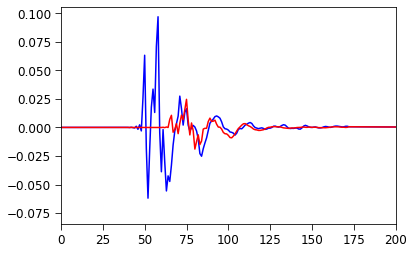

In [135]:
fig, ax = plt.subplots()
ax.plot(brir[:, 0], 'b')
ax.plot(brir[:, 1], 'r')
util_figures.format_axes(
    ax,
    xlimits=[0, 200])
plt.show()


In [136]:
fn = '/om2/user/msaddler/spatial_audio_pipeline/assets/human_experiment_v00/background_musdb18hq/300.wav'
y, sr = sf.read(fn)
ipd.display(ipd.Audio(rate=sr, data=y))
print(brir.shape, brir.dtype)
y_spatial = util_stimuli.spatialize_sound(y, brir)
y_spatial.shape, y_spatial.dtype

ipd.display(ipd.Audio(rate=sr, data=y_spatial.T))


(22050, 2) float64


In [137]:
eng.quit()
